# HuggingFace로  두 문장의 논리적 모순 분류

"기본과제 조건"

- imdb → mnli로 대체
- premise, hypothesis 입력 처리로 수정
- train split에서 validation 분할
- validation_matched 평가
- 로그 및 출력 조건 모두 만족

In [2]:
# 라이브러리 설치
!pip install transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 884.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#라이브러리 import
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
# Dataset준비
# imdb 말고 MNLI 데이터셋 사용
mnli = load_dataset("nyu-mll/glue", "mnli")
mnli

print(mnli[t]


#imdb = load_dataset("imdb")
#imdb

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})


In [5]:
# 데이터 셋 준비
ds = load_dataset("nyu-mll/glue", "mnli")
ds

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

[데이터 구성]

train : 모델 학습용 데이터 (약 393,000개)
validation_matched : 검증용 데이터 (matched 장르: 학습 데이터와 같은 도메인)
validation_mismatched : 검증용 데이터 (mismatched 장르: 학습 데이터와 다른 도메인)
test_matched : 테스트 데이터 (답 없음, matched 장르)
test_mismatched : 테스트 데이터 (답 없음, mismatched 장르)
[데이터 항목 구조]

premise : 전제 문장
hypothesis : 가설 문장
label : 두 문장 간의 관계 (정답 라벨)
0: "entailment", 포함, # 전제가 가설을 포함한다 (포함 관계)
1: "neutral", 중립, # 전제와 가설이 관련 있지만, 확정된 관계는 아님
2: "contradiction", 모순, # 전제와 가설이 모순됨 }

In [6]:
# tokenizer 불러오기
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 전처리 함수 정의
def preprocess_function(data):
    text = []
    for i in range(len(data["premise"])):
        text.append(data["premise"][i] + " " + data["hypothesis"][i])
    data["text"] = text
    return tokenizer(text, truncation=True)
    #truncation : 최대 길이 이상은 짜름

ds_tokenized = ds.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Tokenizer를 실행할 때 넘겨주었던 `truncation` 옵션은 주어진 text가 일정 길이 이상이면 잘라내라는 의미입니다.
만약 특정 길이 값이 같이 주어지지 않는다면 `bert-base-cased`를 학습할 때 사용한 text의 최대 길이를 기준으로 값을 결정합니다.

In [7]:
# 모델구현

from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension : 계산량 줄임
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수 -> hidden_size / num_attention_heads로 나누어 떨어져야 함
config.num_labels = 3  # 마지막에 예측해야 하는 분류 문제의 class 개수 ->
                       # (MNLI - entailment/neutral/contradiction)

#사전학습(pretrained) 모델이 아니고, 완전히 청음부터 학습해야 하는 모델
model = AutoModelForSequenceClassification.from_config(config)

In [ ]:
# train 데이터를 train/validation으로 분할
#mnli_split = mnli_tokenized['train'].train_test_split(test_size=0.1)
#mnli_train, mnli_val = mnli_split['train'], mnli_split['test']
#mnli_test = mnli_tokenized['validation_matched']

#imdb_split = imdb_tokenized['train'].train_test_split(test_size=0.2)
#imdb_train, imdb_val = imdb_split['train'], imdb_split['test']
#imdb_test = imdb_tokenized['test']

## 모델구현


In [9]:
from transformers import BertConfig

# BERT 구성 설정
config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = 3  #  마지막에 예측해야 하는 분류 문제의 class 개수로 MNLI는 3-class분류 문제

#모델 생성
model = AutoModelForSequenceClassification.from_config(config)

## 평가함수

In [10]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## 학습결과

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.

In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=3,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    save_total_limit=1
)
'''
training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=5,  # epoch 수 10-> 5로 줄임
    per_device_train_batch_size=32,  # training data의 batch size
    per_device_eval_batch_size=64,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-4,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="accuracy",
    logging_dir="./logs"
    )'''

'\ntraining_args = TrainingArguments(\n    output_dir=\'hf_transformer\',  # 모델, log 등을 저장할 directory\n    num_train_epochs=5,  # epoch 수 10-> 5로 줄임\n    per_device_train_batch_size=32,  # training data의 batch size\n    per_device_eval_batch_size=64,  # validation data의 batch size\n    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미\n    do_train=True,  # 학습을 진행하겠다는 의미\n    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미\n    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미\n    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미\n    learning_rate=1e-4,  # optimizer에 사용할 learning rate\n    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미\n    metric_for_best_model="accuracy",\n    logging_dir="./logs"\n    )'

각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:
- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.

In [14]:
#중간 에러에 따른 점검문구
print(model)
print(training_args)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 64, padding_idx=0)
      (position_embeddings): Embedding(512, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1e-12, elementwis

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

## Trainer 정의

In [15]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["validation_matched"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-15-d7c4f9c3e5df>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
#학습시작
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wkdth04 (wkdth04-kb-bank) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.000000,0.944436,0.540907
2,0.931100,0.917169,0.562099
3,0.884400,0.912962,0.570250


TrainOutput(global_step=9204, training_loss=0.9385151570903276, metrics={'train_runtime': 1791.4918, 'train_samples_per_second': 657.612, 'train_steps_per_second': 5.138, 'total_flos': 48992679304380.0, 'train_loss': 0.9385151570903276, 'epoch': 3.0})

## 정확도 확인

eval_loss: 손실 값 (낮을수록 좋음)
eval_accuracy: 정확도 (높을수록 좋음)



In [18]:
# 테스트 데이터 평가
eval_result = trainer.evaluate()
print(f"Validation results: {eval_result}")

# 성능 출력
print(f"\n✅ validation_matched accuracy: {eval_result['eval_accuracy']:.4f}")
if eval_result['eval_accuracy'] > 0.5:
    print("🎉 50% 성능을 넘겼습니다!")
else:
    print("❗아쉽게도 50%를 넘지 못했습니다.")

Validation results: {'eval_loss': 0.9129616618156433, 'eval_accuracy': 0.5702496179317371, 'eval_runtime': 7.7123, 'eval_samples_per_second': 1272.642, 'eval_steps_per_second': 159.096, 'epoch': 3.0}

✅ validation_matched accuracy: 0.5702
🎉 50% 성능을 넘겼습니다!


##예측

In [19]:
trainer.predict(ds_tokenized["validation_matched"])

PredictionOutput(predictions=array([[ 0.05618855,  0.06818587, -0.19313864],
       [-1.2580779 , -0.4263703 ,  1.5686733 ],
       [-0.23210385,  0.54466295, -0.3763769 ],
       ...,
       [ 0.39132315, -0.25990057, -0.17850858],
       [ 1.8103071 , -0.04328946, -1.6752511 ],
       [-1.0960834 , -0.9277913 ,  1.9277048 ]], dtype=float32), label_ids=array([1, 2, 0, ..., 0, 0, 2]), metrics={'test_loss': 0.9129616618156433, 'test_accuracy': 0.5702496179317371, 'test_runtime': 8.1909, 'test_samples_per_second': 1198.277, 'test_steps_per_second': 149.8})

In [20]:
# 모델저장
trainer.save_model("mnli_model")

## 손실 및 정확도 시각화하기

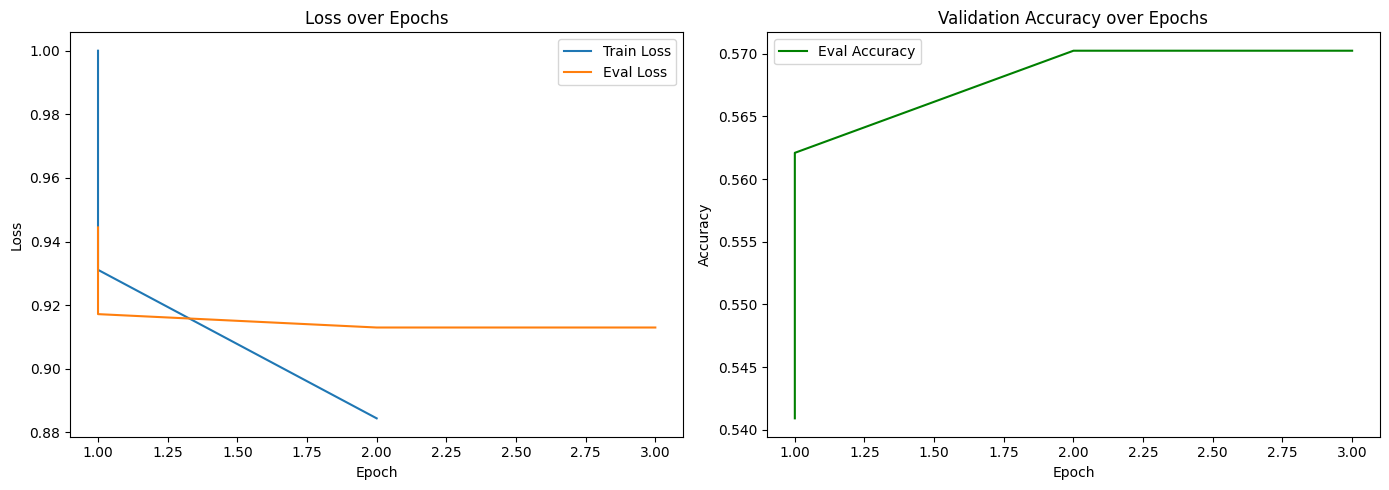

In [23]:
import matplotlib.pyplot as plt

# log 기록을 DataFrame으로 변환
logs = trainer.state.log_history

# 값 저장용 리스트
epochs = []
train_loss = []
eval_loss = []
eval_accuracy = []

# log에서 값 추출
for entry in logs:
    if "epoch" in entry:
        epochs.append(entry["epoch"])
        if "loss" in entry:
            train_loss.append(entry["loss"])
        if "eval_loss" in entry:
            eval_loss.append(entry["eval_loss"])
        if "eval_accuracy" in entry:
            eval_accuracy.append(entry["eval_accuracy"])

# 시각화
plt.figure(figsize=(14, 5))

# 📉 Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# 📈 Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label="Eval Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


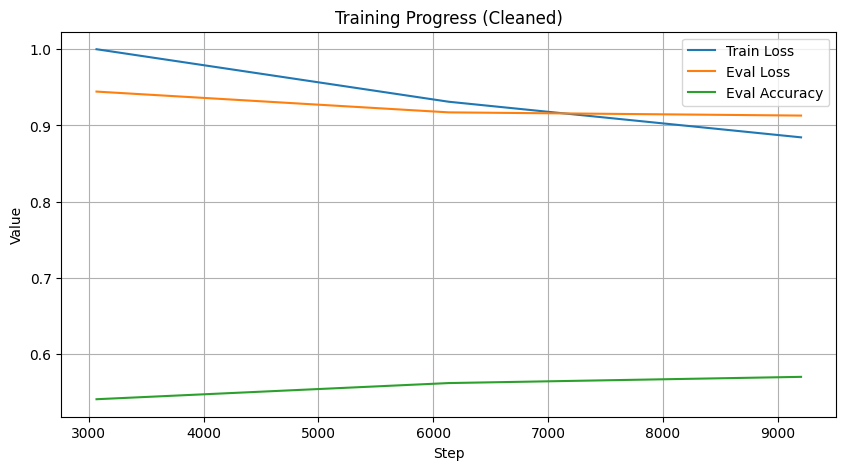

In [24]:
logs = pd.DataFrame(trainer.state.log_history)
x_axis = 'step' if 'step' in logs.columns else 'epoch'

plt.figure(figsize=(10, 5))

# Train Loss
if "loss" in logs.columns:
    plt.plot(
        logs.dropna(subset=["loss"]).drop_duplicates(subset=[x_axis])[x_axis],
        logs.dropna(subset=["loss"]).drop_duplicates(subset=[x_axis])["loss"],
        label="Train Loss"
    )

# Eval Loss
if "eval_loss" in logs.columns:
    plt.plot(
        logs.dropna(subset=["eval_loss"]).drop_duplicates(subset=[x_axis])[x_axis],
        logs.dropna(subset=["eval_loss"]).drop_duplicates(subset=[x_axis])["eval_loss"],
        label="Eval Loss"
    )

# Eval Accuracy
if "eval_accuracy" in logs.columns:
    plt.plot(
        logs.dropna(subset=["eval_accuracy"]).drop_duplicates(subset=[x_axis])[x_axis],
        logs.dropna(subset=["eval_accuracy"]).drop_duplicates(subset=[x_axis])["eval_accuracy"],
        label="Eval Accuracy"
    )

plt.xlabel(x_axis.capitalize())
plt.ylabel("Value")
plt.title("Training Progress (Cleaned)")
plt.legend()
plt.grid(True)
plt.show()

predict() : Trainer 객체로 예측 수행 (logits, label_ids 등 반환)

np.argmax() : 다중 클래스 예측 결과(logits) 중 가장 높은 확률 값을 class로 변환

confusion_matrix() : 실제 정답과 예측값 비교하여 행렬 생성

ConfusionMatrixDisplay : matplotlib 기반 시각화 도구


왼쪽에서 오른쪽으로: 실제 레이블

위에서 아래로: 모델의 예측

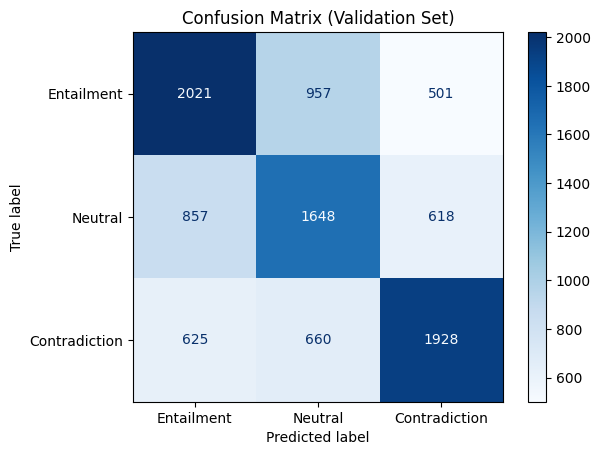

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# validation 데이터셋에 대한 예측 수행
predictions = trainer.predict(ds_tokenized["validation_matched"])

# 예측 결과 중 logits에서 가장 높은 확률을 갖는 class 추출
y_pred = np.argmax(predictions.predictions, axis=1)

# 실제 라벨
y_true = predictions.label_ids

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Entailment", "Neutral", "Contradiction"])
disp.plot(cmap=plt.cm.Blues)  # 색상맵 설정
plt.title("Confusion Matrix (Validation Set)")
plt.show()
